## UK Biobank PCA POC

This demonstrates that randomized PCA can be run on UKB PLINK data in ~50s on 20 8 vCPU nodes.

The array decomposed in the SVD used by PCA is about 60GB (see `call_alternate_allele_count` below).

In [1]:
from dask.distributed import Client
from sgkit.stats.pca import count_call_alternate_alleles
import matplotlib.pyplot as plt
import re
import dask
import sgkit as sg
import xarray as xr
import gcsfs

In [2]:
# * Workarounds for missing sgkit functions * 

def load_dataset(path):
    return xr.open_zarr(gcsfs.GCSMap(path), concat_characters=False, consolidated=True)

def save_dataset(ds, path, chunks):
    for v in ds:
        ds[v].encoding.pop("chunks", None)
    ds = ds.chunk(chunks=chunks)
    ds.to_zarr(gcsfs.GCSMap(path), mode='w', consolidated=True)
    return path

def impute_mean(ds):
    present = ~ds.call_genotype_mask.any(dim='ploidy')
    ac = ds.call_alternate_allele_count.astype('float32')
    aci = ac.where(present).mean(dim='samples')
    ds['call_alternate_allele_count'] = ac.where(present, aci)
    return ds

In [3]:
client = Client()
client

Client Scheduler: tcp://34.75.184.158:8786 Dashboard: http://34.75.184.158:8787/status,Cluster Workers: 20 Cores: 140 Memory: 960.00 GB


### Load PLINK autosomes

In [4]:
urls = !gsutil ls gs://rs-ukb/prep/gt-calls
urls = [u for u in urls if re.match('.*chr\d+.*', u)] # autosomes
urls

['gs://rs-ukb/prep/gt-calls/ukb_chr1.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr10.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr11.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr12.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr13.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr14.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr15.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr16.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr17.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr18.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr19.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr2.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr20.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr21.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr22.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr3.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr4.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr5.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr6.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr7.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr8.zarr/',
 'gs://rs-ukb/prep/gt-calls/ukb_chr9.zarr/

In [5]:
ds = xr.concat([
    xr.open_zarr(gcsfs.GCSMap(url), concat_characters=False, consolidated=True)
    for url in urls
], dim='variants', combine_attrs='drop')
ds

,Array,Chunk
Bytes,766.03 GB,134.22 MB
Shape,"(784256, 488377, 2)","(8192, 8192, 2)"
Count,14302 Tasks,7140 Chunks
Type,int8,numpy.ndarray
,Array,Chunk
Bytes,766.03 GB,134.22 MB
Shape,"(784256, 488377, 2)","(8192, 8192, 2)"
Count,14302 Tasks,7140 Chunks
Type,bool,numpy.ndarray
,Array,Chunk


Select approximately 100k variants and 141k samples to simulate sample using in UKB PCA. See [Genotyping	and	quality	control	of	UK	
Biobank](https://www.ukbiobank.ac.uk/wp-content/uploads/2014/04/UKBiobank_genotyping_QC_documentation-web-1.pdf) (section "Principal components analysis of UK Biobank samples"): 

> We characterised population structure unique to UK Biobank using PCA. First we selected a subset of SNPs ... These filters resulted in 101,284 SNPs for 141,070 samples

### Save a representative subset

In [6]:
%%time
# Every 7th variant corresponds to about 112k variants
ds_sub = ds.isel(variants=slice(None, None, 7), samples=slice(141_070))
save_dataset(ds_sub, 'rs-ukb/tmp/ds_sub.zarr', chunks=dict(variants=8192, samples=8192))
load_dataset('rs-ukb/tmp/ds_sub.zarr')

CPU times: user 2.33 s, sys: 141 ms, total: 2.47 s
Wall time: 1min 3s


,Array,Chunk
Bytes,31.61 GB,134.22 MB
Shape,"(112037, 141070, 2)","(8192, 8192, 2)"
Count,253 Tasks,252 Chunks
Type,int8,numpy.ndarray
,Array,Chunk
Bytes,31.61 GB,134.22 MB
Shape,"(112037, 141070, 2)","(8192, 8192, 2)"
Count,253 Tasks,252 Chunks
Type,int8,numpy.ndarray
,Array,Chunk


### Run QC

In [7]:
%%time
# Set to avoid "PerformanceWarning: Slicing is producing a large chunk."
dask.config.set(**{'array.slicing.split_large_chunks': False})
ds_qc = load_dataset('rs-ukb/tmp/ds_sub.zarr')
ds_qc = ds_qc.pipe(count_call_alternate_alleles).pipe(impute_mean)
# This .persist reduces the filtering times below by at least 50%
ds_qc['call_alternate_allele_count'] = ds_qc['call_alternate_allele_count'].persist()
# Eliminate variants or samples with no variance (these will cause nans in PCA scaler)
ds_qc = ds_qc.isel(variants=ds_qc.call_alternate_allele_count.std(dim='samples') > 0)
ds_qc = ds_qc.isel(samples=ds_qc.call_alternate_allele_count.std(dim='variants') > 0)
ds_qc = ds_qc.drop_vars(['call_genotype', 'call_genotype_mask'])
ds_qc

CPU times: user 4.76 s, sys: 184 ms, total: 4.94 s
Wall time: 1min 25s


<xarray.Dataset>
Dimensions:                      (alleles: 2, samples: 141070, variants: 108621)
Dimensions without coordinates: alleles, samples, variants
Data variables:
    call_alternate_allele_count  (variants, samples) float32 dask.array<chunksize=(7994, 8192), meta=np.ndarray>
    sample_id                    (variants, samples) int32 dask.array<chunksize=(7994, 8192), meta=np.ndarray>
    sample_sex                   (variants, samples) int8 dask.array<chunksize=(7994, 8192), meta=np.ndarray>
    variant_allele               (variants, alleles) |S256 dask.array<chunksize=(7994, 1), meta=np.ndarray>
    variant_contig               (variants) int16 dask.array<chunksize=(7994,), meta=np.ndarray>
    variant_id                   (variants) <U13 dask.array<chunksize=(7994,), meta=np.ndarray>
    variant_position             (variants) int32 dask.array<chunksize=(7994,), meta=np.ndarray>

In [8]:
%%time
save_dataset(ds_qc, 'rs-ukb/tmp/ds_qc.zarr', chunks=dict(variants=8192, samples=8192))

CPU times: user 950 ms, sys: 65.1 ms, total: 1.01 s
Wall time: 58.1 s


'rs-ukb/tmp/ds_qc.zarr'

### Run PCA

In [10]:
ds_pca = load_dataset('rs-ukb/tmp/ds_qc.zarr')
ds_pca = sg.pca(
    ds_pca, n_components=2, ploidy=2, check_missing=False, 
    algorithm='randomized', random_state=0, n_iter=3
)
ds_pca

<xarray.Dataset>
Dimensions:                              (alleles: 2, components: 2, samples: 141070, variants: 108621)
Dimensions without coordinates: alleles, components, samples, variants
Data variables:
    sample_pca_projection                (samples, components) float64 dask.array<chunksize=(8192, 2), meta=np.ndarray>
    sample_pca_component                 (variants, components) float64 dask.array<chunksize=(8192, 2), meta=np.ndarray>
    sample_pca_explained_variance        (components) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_pca_explained_variance_ratio  (components) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    sample_pca_loading                   (variants, components) float64 dask.array<chunksize=(8192, 2), meta=np.ndarray>
    call_alternate_allele_count          (variants, samples) float32 dask.array<chunksize=(8192, 8192), meta=np.ndarray>
    sample_id                            (variants, samples) int32 dask.array<chunksize=(8192, 8192), meta=np.ndarray>
    sample_sex                           (variants, samples) int8 dask.array<chunksize=(8192, 8192), meta=np.ndarray>
    variant_allele                       (variants, alleles) |S256 dask.array<chunksize=(8192, 1), meta=np.ndarray>
    variant_contig                       (variants) int16 dask.array<chunksize=(8192,), meta=np.ndarray>
    variant_id                           (variants) <U13 dask.array<chunksize=(8192,), meta=np.ndarray>
    variant_position                     (variants) int32 dask.array<chunksize=(8192,), meta=np.ndarray>

In [11]:
ds_pca.call_alternate_allele_count

<xarray.DataArray 'call_alternate_allele_count' (variants: 108621, samples: 141070)>
dask.array<zarr, shape=(108621, 141070), dtype=float32, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Dimensions without coordinates: variants, samples

In [12]:
%%time
from dask.distributed import performance_report
with performance_report(filename="pca-performance.html"):
    pcs = ds_pca.sample_pca_projection.compute()
pcs

CPU times: user 736 ms, sys: 18.7 ms, total: 754 ms
Wall time: 49.8 s


<xarray.DataArray 'sample_pca_projection' (samples: 141070, components: 2)>
array([[ 8.13532382,  1.06262173],
       [11.62947793,  7.13108489],
       [ 8.53629776,  1.80501068],
       ...,
       [10.17856992,  1.54351977],
       [11.46498902,  3.3702707 ],
       [12.25762638,  3.75418082]])
Dimensions without coordinates: samples, components

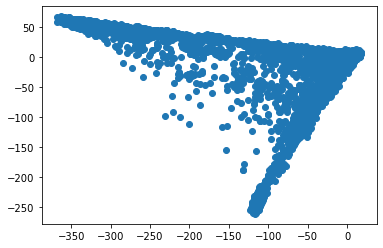

In [15]:
plt.scatter(pcs[:,0], pcs[:,1])

### Axis-wise reduction

This shows speed of simple aggregations for comparison to PCA times.

In [22]:
ds_sub = load_dataset('rs-ukb/tmp/ds_sub.zarr')
ds_sub.call_genotype

,Array,Chunk
Bytes,31.61 GB,134.22 MB
Shape,"(112037, 141070, 2)","(8192, 8192, 2)"
Count,253 Tasks,252 Chunks
Type,int8,numpy.ndarray


In [18]:
%%time
variant_call_rate = ds_sub.call_genotype_mask.any(dim='ploidy').mean(dim='samples').compute()
variant_call_rate.to_series().describe()

CPU times: user 137 ms, sys: 552 µs, total: 138 ms
Wall time: 6.75 s


count    112037.000000
mean          0.029039
std           0.147888
min           0.000035
25%           0.001205
50%           0.002105
75%           0.003870
max           1.000000
Name: call_genotype_mask, dtype: float64

In [23]:
%%time
sample_call_rate = ds_sub.call_genotype_mask.any(dim='ploidy').mean(dim='variants').compute()
sample_call_rate.to_series().describe()

CPU times: user 343 ms, sys: 11.5 ms, total: 355 ms
Wall time: 7.61 s


count    141070.000000
mean          0.029039
std           0.005057
min           0.023287
25%           0.025545
50%           0.027500
75%           0.031034
max           0.108259
Name: call_genotype_mask, dtype: float64

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
